### Tutorial for Bayesian Optimization:


Source: Practical Bayesian Optimization of Machine Learning Algorithms

Link: https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Our imports 
from gp import GP, SquaredExp, Matern52
import sampling as s


sns.set_palette('muted',color_codes=True)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plotting helpers         
def plot_draws(x,draws):
    """ Plot the draws from the GP prior or posterior """
    for p in draws.T:
        plt.plot(sorted(x),sorted(p,key=dict(zip(p, x)).get),alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('prior y')
    sns.despine()

def plot_posterior(post_means, post_std, xp):
    sorted_x = sorted(xp.ravel())
    sort_means = np.array(sorted(post_means,key=dict(zip(post_means, xp.ravel())).get))
    sort_std = np.array(sorted(post_std,key=dict(zip(post_std, xp.ravel())).get))
    
    plt.plot(sorted_x,sort_means,alpha=0.7, label='Posterior Mean')
    plt.gca().fill_between(sorted_x, sort_means-3*sort_std, sort_means+3*sort_std, alpha=0.3)

### Draws from the prior distribution

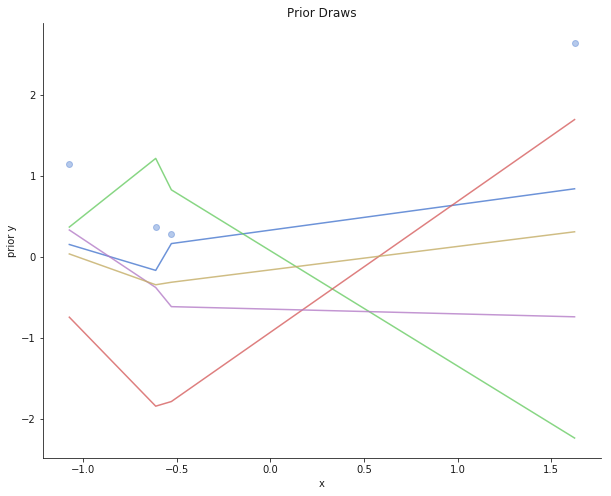

In [3]:
# Example - Initials 
np.random.seed(1)
x = np.random.randn(4,1)
y = x**2

# Make GP
ggp = GP(x,y,Matern52)
# ggp = GP(x,y,SquaredExp)

# Draw prior functions from GP
prior_draws = ggp.draw_prior(5)

# Plotting prior functions 
plt.figure(figsize=(10,8))
plt.scatter(x,y,alpha=0.4)
plot_draws(x,prior_draws)
plt.title('Prior Draws')
plt.show()

### Draws from the posterior and posterior predictive distribution

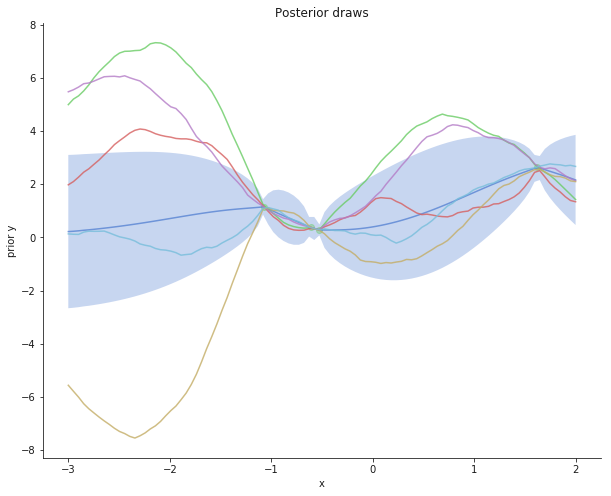

In [4]:
np.random.seed(5)
xp = np.linspace(-3,2,100).reshape(-1,1)

# Draw from the posterior and posterior predictive
post_means, post_stds = ggp.draw_posterior(xp)
pp_draws = ggp.draw_posterior_pred(5)

# Plotting posterior and posterior predictive 
plt.figure(figsize=(10,8))
plot_posterior(post_means, post_stds, xp)
plt.scatter(x,y,alpha=0.4)
plot_draws(xp,pp_draws)
plt.title('Posterior draws')
sns.despine()
plt.show()

### Lets look at all the available acquisition functions

* Probability of Improvement 
* Expected Improvement 
* GP Lower Confidence Bound 

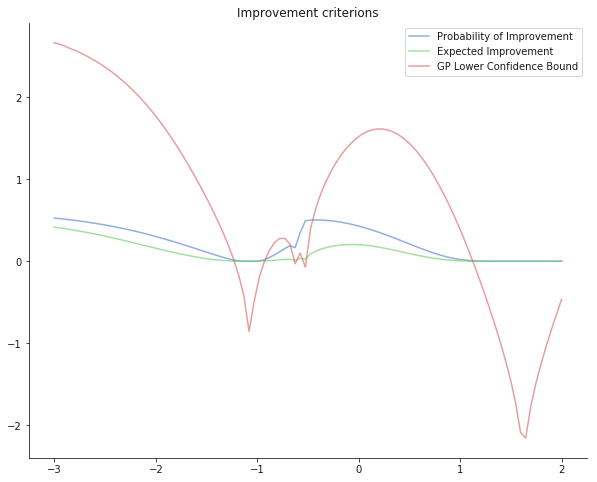

In [5]:
# Plotting the different improvement criterions 
plt.figure(figsize=(10,8))
plt.plot(xp,ggp.pi_metric(xp),label='Probability of Improvement',alpha=0.6)
plt.plot(xp,ggp.ei_metric(xp),label='Expected Improvement',alpha=0.6)
plt.plot(xp,ggp.ucb_metric(xp,3),label='GP Lower Confidence Bound',alpha=0.6)
# plt.plot(xp,post_means,label='Mean of Posterior',alpha=0.6)
plt.title('Improvement criterions')
plt.legend()
sns.despine()


### Different $\theta$'s for varying GP hyperparameters

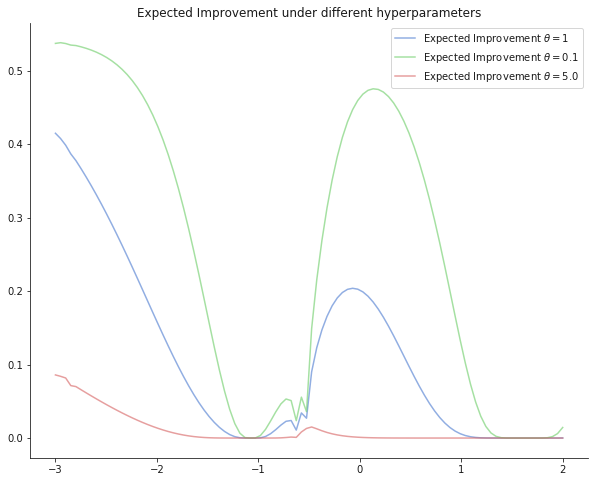

In [6]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=1$',alpha=0.6)
ggp.thetas = np.array([0.5])
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=0.1$',alpha=0.6)
ggp.thetas = np.array([5.0])
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=5.0$',alpha=0.6)
plt.title('Expected Improvement under different hyperparameters')
plt.legend()
sns.despine()

# Reset thetas 
ggp.thetas = np.array([1.0])

### Example with a simple function, $f(x)=x^2$

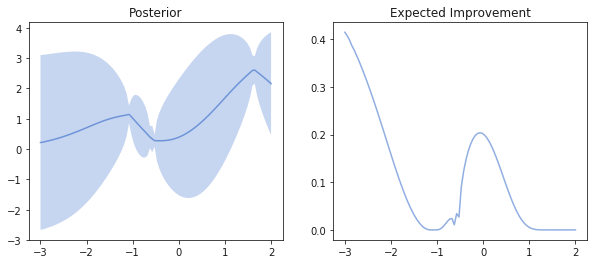

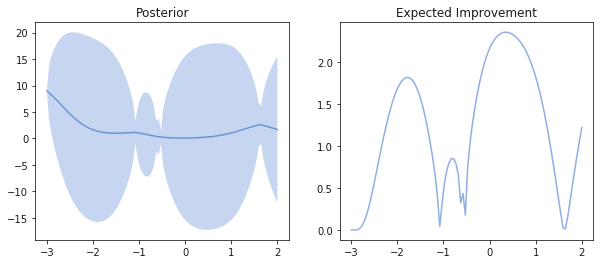

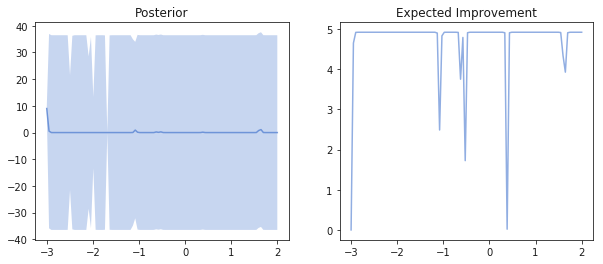

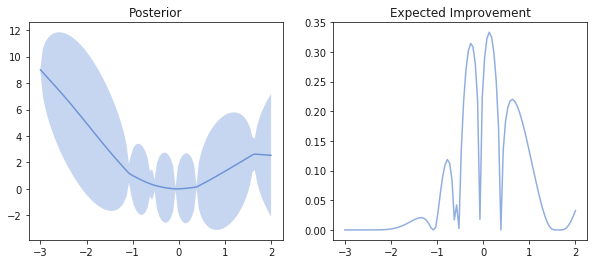

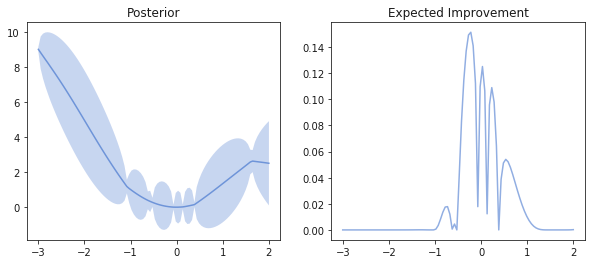

In [7]:
func = lambda x: x**2
hist = []
for i in range(5):
    # Plotting
    post_means, post_stds = ggp.draw_posterior(xp)
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plot_posterior(post_means, post_stds, xp)
    plt.title('Posterior')
    
    plt.subplot(122)
    plt.plot(xp,ggp.ei_metric(xp),label=f'Expected Improvement at {i}',alpha=0.6)
    plt.title('Expected Improvement')
    plt.show()
    
    # The actual bayesian optimization part
    next_prop = ggp.next_proposal(xp)
    next_val = xp[next_prop].reshape(-1,xp.shape[1])
    prop_res = func(next_val).reshape(-1,1)
    ggp.obsx = np.append(ggp.obsx, next_val, axis=0)
    ggp.obsy = np.append(ggp.obsy, prop_res, axis=0)
    hist.append((next_prop,prop_res))


In [8]:
print(f'The optimal x value we found was: {xp[min(hist,key= lambda x: x[1])[0]]}')

The optimal x value we found was: [-0.07070707]


### Here is the whole process for $f(x)=x^2$

In [9]:
np.random.seed(1)
func = lambda x: x**2
x = np.random.randn(4,1)
y = func(x)

# Make GP
ex_gp = GP(x,y,Matern52)

x_proposed = np.linspace(-5,5,100).reshape(-1,1)
best_res, ex_hist = ex_gp.find_best(func,x_proposed,iters=10)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [10]:
print(f'Best result was {best_res[1]} achieved at x = {best_res[0]}')

Best result was [[0.00255076]] achieved at x = [[0.05050505]]


### Example with Rosenbrock

In [11]:
np.random.seed(1)
rosen = lambda x: (1-x[:,0])**2+100*(x[:,1]-x[:,0]**2)**2
rx = np.random.randn(4,2)
ry = rosen(rx)

# Make GP
rosen_gp = GP(rx,ry,Matern52)

rx_proposed = np.array(np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))).reshape(-1,2)
best_res, rosen_hist = rosen_gp.find_best(rosen,rx_proposed,iters=10)

100%|██████████| 10/10 [02:28<00:00, 14.81s/it]


Best result was [1.64590868] achieved at x = [0.10204082 0.10204082]


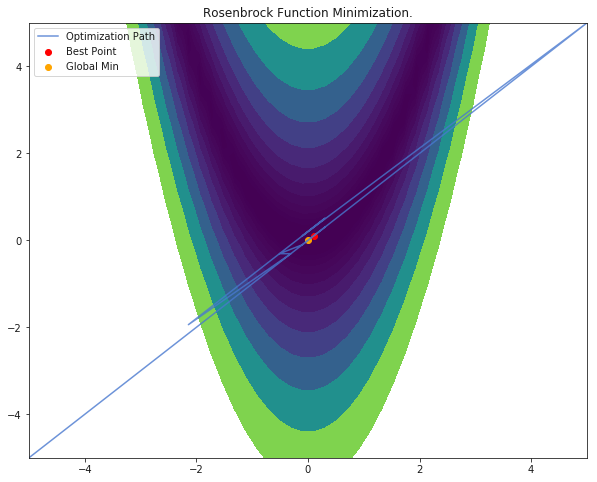

In [12]:
# Plot the above reesults 
rosenbrockfunction = lambda x,y: (1-x)**2+100*(y-x**2)**2
X,Y = np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
Z = rosenbrockfunction(X,Y)

# Plotting 
plt.figure(figsize=(10,8))
plt.contourf(X,Y,Z,np.logspace(-0.5,3.5,20,base=10))
plt.plot([i[0][0][0] for i in rosen_hist],[i[0][0][1] for i in rosen_hist],alpha=0.8,label='Optimization Path')
plt.scatter(*best_res[0].ravel(),c='red',label='Best Point')
plt.scatter(0,0,c='orange',label='Global Min')
plt.title('Rosenbrock Function Minimization.')
plt.legend()

# Print results 
print(f'Best result was {best_res[1][0]} achieved at x = {best_res[0][0]}')

### Example with sklearn model

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load the data 
x_iris, y_iris = load_iris(True)
iris_trx,iris_testx,iris_try,iris_testy = train_test_split(x_iris,y_iris,random_state=42)

# Get some initial points 
hp_x = np.array([[1e-1],[1e-2],[1e-4]])
hp_y = np.zeros(3)
for i,hp in enumerate(hp_x):
    log_reg = LogisticRegression(C=hp[0],random_state=42).fit(iris_trx,iris_try)
    test_acc = log_reg.score(iris_testx,iris_testy)
    hp_y[i] = -test_acc
    
# Make the function we want to minimize
def iris_opt(hp):
    log_reg = LogisticRegression(C=hp.ravel()[0],random_state=42).fit(iris_trx,iris_try)
    test_acc = log_reg.score(iris_testx,iris_testy)
    return -test_acc

# Make the GP instance 
iris_gp = GP(hp_x,hp_y,Matern52)

# Propose points 
c_prop = np.linspace(0,10,100).reshape(-1,1)

# Do the bayesian optimization
best_res_iris, ir_hist = iris_gp.find_best(iris_opt,c_prop,iters=10)

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


In [14]:
log_reg = LogisticRegression(C=best_res_iris[0][0][0],random_state=42).fit(iris_trx,iris_try)
test_acc = log_reg.score(iris_testx,iris_testy)
print(f'Bayesian optimization procedure found C = {best_res_iris[0][0][0]} to get test accuracy of: {test_acc}')

Bayesian optimization procedure found C = 4.141414141414141 to get test accuracy of: 1.0


### Example with deep learning
* Right now we do just external hp's but we could do internal if we were feeling frisky
* e.g. optimize number of layers and width of layers 

In [15]:
####################### GLOBALS #########################
# To use GPU's or not to use GPU's?
use_cuda = torch.cuda.is_available()

# Get mnist data - Note: if this fails switch download to True
train_set = dset.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=False)
test_set = dset.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Get the x and y tensors from test for quick evaluation 
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)
for test_x, test_y in test_loader:
    test_x = Variable(test_x,volatile=True) if not use_cuda else Variable(test_x.cuda(),volatile=True)
    test_y = Variable(test_y,volatile=True) if not use_cuda else Variable(test_y.cuda(),volatile=True)
    
##########################################################
    
# Define the CNN we will be working with 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

def train(model, opt, lossf, data_loader, epochs, use_cuda=False):
    """ Simple function to train a PyTorch model """
    for e in range(epochs):
        for bx,by in data_loader:
            bx = Variable(bx) if not use_cuda else Variable(bx.cuda())
            by = Variable(by) if not use_cuda else Variable(by.cuda())
            opt.zero_grad()
            
            result = model(bx)
            loss = lossf(result,by)
            
            loss.backward()
            opt.step()

            
def torch_try_hp(hps):
    """ Function to try different hyperparameters and return the validation set loss """
    # Types need to be: int, float, int, float
    bs, lr, epochs, reg = hps.ravel()
    
    # Set training loaders 
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=int(bs), shuffle=True)
    
    # Initialize model 
    model = CNN() if not use_cuda else CNN().cuda()
    opt = optim.SGD(model.parameters(), lr=lr, weight_decay=reg, momentum=0.9)
    loss_func = nn.NLLLoss()
    train(model, opt, loss_func, train_loader, epochs=int(epochs), use_cuda=use_cuda)
    
    # Get test loss
    test_result = model(test_x)
    test_loss = loss_func(test_result, test_y)
    test_loss = test_loss.data.numpy() if not use_cuda else test_loss.data.cpu().numpy()
    
    return test_loss[0]
    

### Bayesian optimization over hyperparameters of a CNN 

* Note: do not rerun this unless you have a GPU and plenty of time to spare.

In [16]:
# Get some initial points 
hps_x = np.array([[32.0, 0.001, 10.0, 0.01],
                  [64.0, 0.01, 10.0, 0.1],
                  [128.0, 0.001, 5.0, 0.01]])
hps_y = np.zeros(3)
for i,hp in enumerate(hps_x):
    test_loss = torch_try_hp(hp)
    hps_y[i] = test_loss
    
# Make the GP instance 
mnist_gp = GP(hps_x, hps_y, Matern52)

# Propose points 
batch_sizes = np.arange(32,256,32)
learning_rates = np.linspace(0,.5,20)
epochs = np.arange(2,50,4)
reg_params = np.linspace(0,1,20)

# Make the mesh 
mnist_mesh = np.meshgrid(batch_sizes, learning_rates, epochs, reg_params)
mnist_prop = np.array(mnist_mesh).T.reshape(-1,len(mnist_mesh))

# Do the bayesian optimization
best_res_mnist, mnist_hist = mnist_gp.find_best(torch_try_hp, mnist_prop, iters=10)

100%|██████████| 10/10 [3:14:12<00:00, 1165.29s/it] 


In [17]:
batch_size, lr, epochs, reg_par = min(mnist_hist,key=lambda x: x[1])[0][0]
print(f'We acheived best performance of loss = {min(mnist_hist,key=lambda x: x[1])[1][0][0]}')
print(f'Parameters were batch = {batch_size}, lr= {round(lr,4)}, epochs = {epochs}, and reg param = {reg_par}')

We acheived best performance of loss = 0.038938265293836594
Parameters were batch = 224.0, lr= 0.0263, epochs = 38.0, and reg param = 0.0


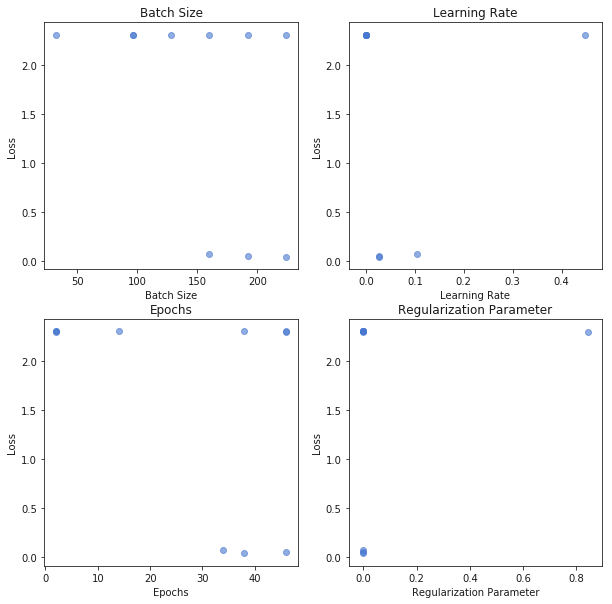

In [18]:
names = ['Batch Size', 'Learning Rate', 'Epochs', 'Regularization Parameter']
params_tried = np.array([m[0][0] for m in mnist_hist])
losses_recorded = np.array([m[1][0] for m in mnist_hist])

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(params_tried[:,i], losses_recorded, alpha=0.6)
    plt.title(names[i])
    plt.xlabel(names[i])
    plt.ylabel('Loss')

In [19]:
# Now lets put it to use
use_cuda = torch.cuda.is_available()

# Set training loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=int(batch_size), shuffle=True)
    
# Initialize model 
model = CNN() if not use_cuda else CNN().cuda()
opt = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_par, momentum=0.9)
loss_func = nn.NLLLoss()
train(model, opt, loss_func, train_loader, epochs=int(epochs), use_cuda=use_cuda)

print('Training done. Model ready!')

Training done. Model ready!


In [20]:
# Accuracy measures
def accuracy(model,x,y,use_cuda=False):
    """ Get classification accuracy for a torch model (or any function that can take
    torch Variables as input).
    ---------
    Args: model; a torch model, or any function that can take torch Variable inputs
          x; torch Tensor object to be made into a Variable before running through
                model.
          y; torch Tensor with outputs of classification for comparison with model(x)
    ---------
    Returns: float; the classification accuracy of the model.
    """
    if use_cuda:
        probs = model(Variable(x.cuda(),volatile=True))
        _,ypred = torch.max(probs,1)
        return (ypred.data.cpu().numpy()==y.cpu().numpy()).sum()/len(y)
    else:
        probs = model(Variable(x, volatile=True))
        _,ypred = torch.max(probs,1)
        return (ypred.data.numpy()==y.numpy()).sum()/len(y)
    
train_load_acc = torch.utils.data.DataLoader(dataset=train_set, batch_size=len(train_set), shuffle=False)
for x,y in train_load_acc:
    print('Train accuracy:',accuracy(model,x,y,use_cuda))

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)
for x,y in test_loader:
    print('Test accuracy: ',accuracy(model,x,y,use_cuda))

Train accuracy: 0.9896666666666667
Test accuracy:  0.9818


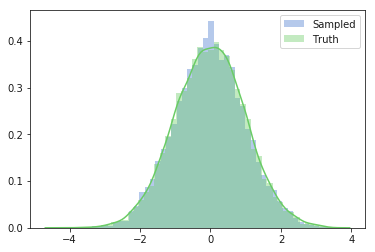

In [21]:
### TEST FOR SLICE SAMPLING ###
import scipy.stats as ss
from scipy.special import kl_div
import sampling as s

np.random.seed(999)
nsamps=10000
trace = np.zeros(nsamps)

res = 0.0
for i in range(nsamps):
    res = s.slice(ss.norm.logpdf,[res])
    trace[i] = res
    
true_norm = np.random.normal(size=10000)
sns.distplot(trace,label='Sampled',kde=False,norm_hist=True)
sns.distplot(true_norm,label='Truth')
plt.legend()

assert(np.isclose(trace.mean(),true_norm.mean(),atol=1e-1))
assert(np.isclose(trace.std(),true_norm.std(),atol=1e-2))